# pulse2percept: Processing Images

This notebook illustrates the use of pulse2percept to convert a conventional grayscale or RGB image into a percept.

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import pulse2percept as p2p

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2017-10-31 18:48:05,191 [pulse2percept] [INFO] Welcome to pulse2percept


## 1. Setting up the Simulation

### 1.1 Choosing the Stimulus

Here we specify whether we want to encode an image `datafile` using amplitude coding ('amplitude') or frequency coding ('frequency'). We can also invert the luminance levels of the image:

In [2]:
encoding = 'amplitude'
invert = True
datafile = 'letters/A.jpg'
savefile = 'percept-A.mp4'

## 1.2 Setting up the Implant

These steps are equivalent to [0.0-example-usage.ipynb](0.0-example-usage.ipynb):

In [3]:
# Place an Argus I array centered on the fovea
argus = p2p.implants.ArgusII(h=0)

In [4]:
sim = p2p.Simulation(argus, engine='joblib', n_jobs=-1)

If you don't specify the grid ranges (`x_range`, `y_range`), the grid will be adjusted to the size of the implant, as can be seen in the fundus plot below:

In [5]:
# Set parameters of the optic fiber layer (OFL)
# In previous versions of the model, this used to be called the `Retina`
# object, which created a spatial grid and generated the axtron streak map.

# Set the spatial sampling step (microns) for the retinal grid.
s_sample = 100
sim.set_optic_fiber_layer(sampling=s_sample, sensitivity_rule='decay', decay_const=5.0)

2017-10-31 18:48:05,409 [pulse2percept.retina] [INFO] Loading file "./retina_RE_s100_a501_r801_6000x4000.npz".


In [6]:
# Set parameters of the ganglion cell layer (GCL)
# In previous versions of the model, this used to be called `TemporalModel`.

# Set the temporal sampling step (seconds) for all GCL computations
t_sample = 0.01 / 1000
sim.set_ganglion_cell_layer('Nanduri2012', tsample=t_sample)

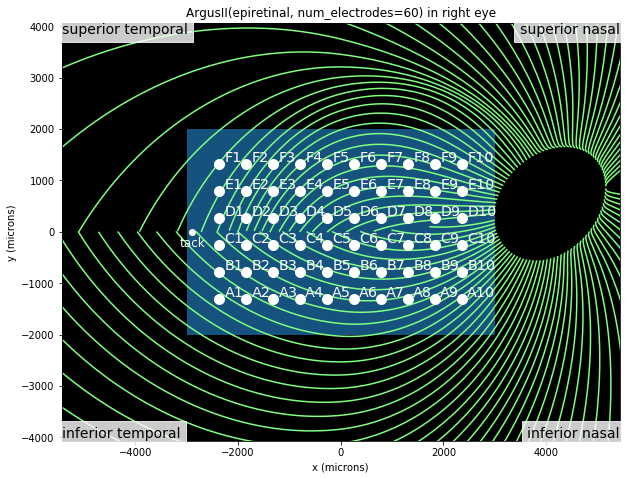

In [7]:
sim.plot_fundus();

### 1.3 Setting up the Stimulus

The easiest way to convert an image into a pulse train is to pass a filename to `p2p.stimuli.image2percept`.

However, here we want to look at the image first. For this we will use Scikit-Image:

In [8]:
import skimage.io as sio
import skimage.transform as sit

First, we load the image in grayscale mode, and cut out the (empty) borders:

In [9]:
img_in = sio.imread(datafile, as_gray=True)
img_in = img_in[50:150, 40:200]

Then, to get an idea what the image will look like to a low-resolution Argus II array, we downsample the image to a 6x10 grid. Optionally, we also invert the grayscale levels:

In [10]:
img_stim = sit.resize(img_in, (6, 10))
if invert:
    img_stim = 1.0 - img_stim

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


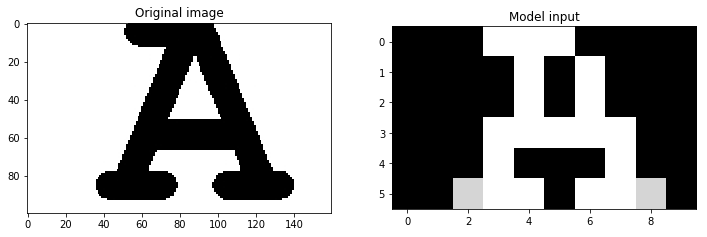

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(img_in, cmap='gray')
plt.title('Original image')
plt.subplot(122)
plt.imshow(img_stim, cmap='gray')
plt.title('Model input');

This image can now be passed to `p2p.stimuli.image2pulsetrain`. `valrange` specifies the range of values to be used for converting grayscale values between 0 and 255 into either amplitude or frequency values in `valrange`. For amplitude coding, the frequency is held constant at `const_val`, which can also be specified. 

In [12]:
stim = p2p.stimuli.image2pulsetrain(img_stim, argus, valrange=[0, 10], tsample=t_sample)

## 2. Running the Simulation

This is the same as before. Simply pass the stimulus `stim` to `sim.pulse2percept`:

In [13]:
percept = sim.pulse2percept(stim, t_percept=t_sample, tol=0.25, layers=['GCL', 'OFL'])

2017-10-31 18:48:07,066 [pulse2percept.api] [INFO] Starting pulse2percept...
2017-10-31 18:48:34,011 [pulse2percept.api] [INFO] tol=25.0%, 2346/2501 px selected
2017-10-31 19:35:38,004 [pulse2percept.api] [INFO] Done.


## 3. Analyzing the Output

In [14]:
frame = p2p.get_brightest_frame(percept)

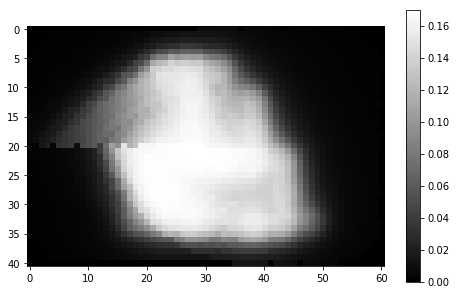

In [15]:
plt.figure(figsize=(8, 5))
plt.imshow(frame.data, cmap='gray', vmin=0)
plt.grid('off')
plt.colorbar()

In [16]:
p2p.files.save_video(percept, savefile, fps=20)

2017-10-31 19:35:38,943 [pulse2percept.files] [INFO] Saved video to file 'percept-A.mp4'.
